In [24]:
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import agent
import blockworld
import model

In [15]:
from utils import get_data
version = '1.1'
data = get_data(version, '../data')
df = data['blockworld']

def parse_state(state):
    return tuple((tuple(filter(None, col.split(','))) 
                  for col in state.split(':')))

df.states = df.states.apply(lambda states: list(map(parse_state, states)))

In [29]:
df['initial_state'] = df.states.apply(lambda states: states[0])
df['num_actions'] = df['states'].apply(lambda states: len(states) - 1)
df['num_blocks'] = df['initial_state'].apply(blockworld.Blockworld.count_blocks)

Counter({3: 31, 10: 1, 12: 1, 4: 1, 5: 3, 31: 1, 7: 1, 17: 1, 19: 1, 6: 1})

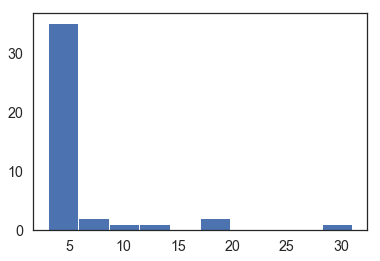

In [54]:
from collections import Counter
ct = [row.num_actions for _, row in df.loc[df.initial_state == (('A', 'C'), (), ('B',))].iterrows()]
plt.hist(ct)
Counter(ct)

In [55]:
initial_to_limit = {}
for initial, rows in df.groupby('initial_state'):
    p95 = rows.num_actions.quantile(0.95)
    initial_to_limit[initial] = int(np.ceil(p95))

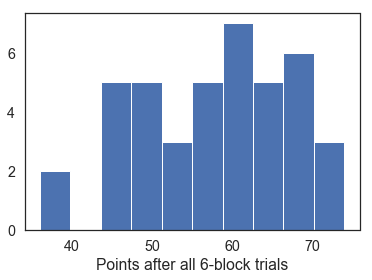

In [35]:
# simulation ish?
# for each subject, how many points would they get?
final_points = []
for pid, rows in df.loc[df.num_blocks==6].groupby('pid'):
    points = 0
    for _, row in rows.iterrows():
        point_limit = initial_to_limit[row.initial_state]
        points += max(0, point_limit - row.num_actions)
    final_points.append(dict(pid=pid, points=points))

final_points = pd.DataFrame(final_points)

f, ax = plt.subplots()
ax.hist(final_points.points)
ax.set_xlabel('Points after all 6-block trials')

None

In [74]:
print('Expected final points.', final_points.points.mean() * 4)

Expected final points. 230.53658536585365


In [66]:
# Adding things to make new trials.json
import json
with open('../../cocosci-blockworld/static/json/trials.json', 'rb') as f:
    trials = json.load(f)

def make_json_entry(state, points):
    letters = sorted([l for col in state for l in col], reverse=True)
    return dict(
        initial_points=points,
        initial=state,
        goal=((), tuple(letters), ()),
    )

make_json_entry(trials['B=3'][0]['initial'], 6)

{'initial_points': 6,
 'initial': [['A', 'C'], [], ['B']],
 'goal': ((), ('C', 'B', 'A'), ())}

In [79]:
sixblock_probs = [
    (('F',), ('B', 'D', 'A', 'C', 'E'), ()),
    (('E',), ('D', 'B', 'A', 'C'), ('F',)),
    (('F',), ('D', 'A', 'B', 'C'), ('E',)),
    (('F', 'E'), ('B', 'D', 'C', 'A'), ()),
    (('F', 'B'), ('D', 'A', 'C', 'E'), ()),
    (('E', 'B'), ('A', 'D'), ('F', 'C')),
    (('E',), ('C', 'A', 'D'), ('F', 'B')),
    (('E',), ('C',), ('F', 'B', 'A', 'D')),
    (('E', 'D'), (), ('F', 'C', 'A', 'B')),
    (('F', 'E', 'A'), ('B', 'C'), ('D',)),
    (('F', 'E', 'C'), ('B', 'A'), ('D',)),
    (('E',), ('B',), ('F', 'C', 'D', 'A')),
    (('F', 'C', 'E'), ('A',), ('D', 'B')),
    ((), ('A', 'C', 'E', 'F'), ('D', 'B')),
    (('F', 'C', 'B', 'A'), (), ('D', 'E')),
    (('F', 'D'), ('B', 'C'), ('E', 'A')),
]
sixblock_probs = [dict(initial=s) for s in sixblock_probs]
max_limit = max(initial_to_limit.values())
print('Max Limit', max_limit, 'Limits', initial_to_limit.values())

def handle_old_entry(entry):
    tuple_initial = tuple(tuple(col) for col in entry['initial'])
    if tuple_initial in initial_to_limit:
        lim = initial_to_limit[tuple_initial]
    else:
        print(f'No limit found for {tuple_initial}. Using max.')
        lim = max_limit
    return make_json_entry(entry['initial'], lim)

out = {
    # Point count based on optimal * 2
    'B=3': [make_json_entry((('A', 'C'), (), ('B',)), 6)],
    # Point counts based on number of moves it took cgc * 2
    # HACK although based on user performance we decreased points from 18 to 13
    'B=4': [make_json_entry(((), ('A', 'B', 'D'), ('C',)), 13)],
    'B=5': [make_json_entry((('E', 'C'), ('B', 'A'), ('D',)), 22)],
    # Point counts based on p95 it took subjects
    'B=6': [
        handle_old_entry(entry)
        for entry in sixblock_probs
    ]
}

with open('new-trials.json', 'w') as f:
    json.dump(out, f)

Max Limit 24 Limits dict_values([14, 15, 24, 14, 17, 18, 15, 13, 13, 20, 20, 20, 22, 20, 20, 22, 21, 24, 16, 19, 20, 22, 17, 17, 18])
No limit found for (('F', 'B'), ('D', 'A', 'C', 'E'), ()). Using max.
No limit found for (('E', 'D'), (), ('F', 'C', 'A', 'B')). Using max.


In [83]:
for k, items in out.items():
    print(k, 'num items', len(items))


states = [e['initial'] for e in out['B=6']]
for s in states:
    if s[::-1] in states:
        print('BAD! found duplicate entry...')

B=3 num items 1
B=4 num items 1
B=5 num items 1
B=6 num items 16
